# Fully Connected Layer
> "Creating a fully-connected layer"

- toc:true- branch: master- badges: true- comments: true
- author: Ivan Dolgushev
- categories: [fastpages, deeplearning]

In [1]:
#hide
%load_ext autoreload
%autoreload 2
%matplotlib inline
import seaborn

### Foward and backward passes

In [9]:
#hide
import sys
sys.path.append("..") # Adds higher directory to python modules path.
from exp.nb_MatrixExample import *

In [10]:
def get_data():
   
    path = datasets.download_data(MNIST_URL, ext='.gz')
    with gzip.open(path, 'rb') as f:
        (x_train, y_train),(x_valid, y_valid), _ = pickle.load(f, encoding='latin-1')
    return map(tensor, (x_train,y_train, x_valid,y_valid))

def normalize(x,m,s): return (x-m) / s

Let's grab for this example [MNIST](http://yann.lecun.com/exdb/mnist/) data. MNIST data is a popular dataset for machine learning and deep learning and conists of handwritted digits from 0 to 9. By modern standards the dataset is considered to be trivial with many algorithms reaching >99% test accuracy.

 MNIST has a training set of 60,000 examples, and a test set of 10,000 examples.
 
 There are many different ways to grab MNIST dataset. We leverage FastAI `datasets`

In [11]:
x_train, y_train, x_valid, y_valid = get_data()

In [12]:
x_train.shape, x_valid.shape

(torch.Size([50000, 784]), torch.Size([10000, 784]))

Our training set has 50 000 observations, each observation has 784 data points. This represents flattened 28 x 28 pixels of the resulting image. We can convert 784 vector back to a matrix form and plot it for vizualization

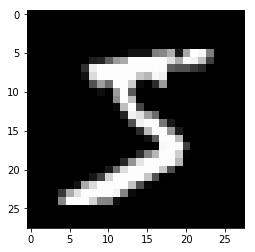

In [13]:
mpl.rcParams['image.cmap'] = 'gray'

plt.imshow(x_train[0].view(28,28));

### Preparing the data

As a usual first step we normalize our data - subtract the mean and divide by the standard deviation of the __train dataset__. it is important to use the same mean and standard deviation while normalizing training and validation / test data

In [14]:
train_mean, train_std = x_train.mean(), x_train.std()
train_mean, train_std

(tensor(0.1304), tensor(0.3073))

In [15]:
# normalizing the data
x_train = normalize(x_train, train_mean, train_std)
x_valid = normalize(x_valid,train_mean, train_std)

In [16]:
def test_near_zero(a, tol=1e-3): assert a.abs() < tol, f"Near zero: {a}"

In [17]:
test_near_zero(x_train.mean())
test_near_zero(1 - x_train.std())

In [18]:
n,m = x_train.shape
c = y_train.max() + 1
n,m,c

(50000, 784, tensor(10))

### Starting version

Let's define the number of hidden layers

In [19]:
nh = 50

Initialization of weights is __crucial__ to the training of the neural net. Using poor initialization could lead to very slow convergence of the loss function or even exploding. If weights are below 1, they will get smaller and smaller until they almost vanish and does not contribute to network learning.

We can look at a simplified example, inspired by [post](https://prateekvjoshi.com/2016/03/29/understanding-xavier-initialization-in-deep-neural-networks/), to understand why weights are important. If our input for activation __z__ is near zero, sigmoid activation function degenerates to a linear one, which means it does not bring any new information. On the other hand, if **z** becomes too big or too small, activation function is flat at these areas and its gradient is approaching zero. We want the variance and bias for each layer to remain stable.

We  often don't worry about this as deep learning frameworks implement the necessary weights initialization under the hood, but it is still important to understand why it matters this much. I discuss weight initialization in greater details in separate posts.

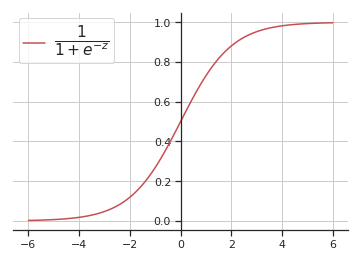

In [20]:
#collapse
seaborn.set(style='ticks')
z = torch.linspace(-6,6,100)
sigmoid = [1 / (1 + math.exp(-x)) for x in z]
fig, ax = plt.subplots()

ax.plot(z, sigmoid, c='r', label = r"$ \frac{1}{1+e^{- z}}$")
ax.grid(True, which='both')

seaborn.despine(ax=ax, offset=0)
ax.spines['left'].set_position('zero')

ax.legend()

plt.setp(ax.get_legend().get_texts(), fontsize='22');

The goal is for each layer to have mean of 0.0 and variance  of 1.0 for every layer in order to avoid gradient vanishing or exploding. This issues was tackled by Xavier in his paper [Understanding the difficulty of training deep feedforward neural networks](http://proceedings.mlr.press/v9/glorot10a.html).

Let's briefly discuss the reasoning behind his approach. <br>
Consider a fully-connected linear layer: $$ y = x * w + b$$ which is $$ y = x_{1}*w_{1} + x_{2}*w_{2} + ... + x_{N}*w_{N} + b $$. 

Our goal is to make the variance of $y$ equal to $1$. Assuming independence between $x$ and $y$ we have the following formula: 

$$Var(x*y) = Var(x)*Var(y) + (Var(x)*E(y))^2 + (Var(y)*E(x))^2$$

In our case $w_{i}$ was drawn from normal distrubution with zero mean and $x$ were normalized , thus for each i-th term we have:

$$ Var(x_{i}*w_{i}) = Var(x_{i}) * Var(w_{i}) + (Var(x_{i})*0)^2 + (1 * 0) ^2  = Var(x_{i}) * Var(w_{i})) $$

We have N identically distributed elements, thus:
$$ Var(y) = \sum_{i=1}^{N} Var(x_{i}) * Var(w_{i}) = N * Var(x_{i}) * Var(w_{i}))  $$

We want our input to the activation function ($y$) to have the same variance as the previous layer ($x$) in order to have stability in the system. This implies, that 

$$ N * Var(w_{i}) = 1 $$ 
$$or$$ 
$$ Var(w_{i}) = 1 / N $$

This is what is called _Xavier_ initialization. Let's proceed with it below.

In [21]:
# Xavier initialization
w1 = torch.randn(m, nh) / math.sqrt(m)
b1 = torch.zeros(nh)
w2 = torch.randn(nh,1) / math.sqrt(nh)
b2 = torch.zeros(1)

In [22]:
# check that mean and variance are equal to 0 and 1
test_near_zero(w1.mean())
test_near_zero(w1.std() - 1/math.sqrt(m))

Let's define a simple linear layer:

In [23]:
def lin(x,w,b): return x @ w + b

In [24]:
t = lin(x_train, w1, b1)

In [25]:
t.mean(), t.std()

(tensor(0.0198), tensor(1.0244))

As we see, after applying linear layer, we succeeded in our goal - mean and variance of the input to activation function is 0 and 1 (almost). But this is not the end of the story - we have to actuall pass the results through the activation function. And the results itself will be the input to the next layer.

In [26]:
def relu(x): return x.clamp_min(0)

In [27]:
t = relu(lin(x_train, w1, b1))
t.mean(), t.std()

(tensor(0.4137), tensor(0.5895))

After applying relu our mean and variance are distorted - relu clamps all negative values to zero, thus reducting variance by half and shifting mean by 0.5. We have to take into account when initializing the weigths. This is addressed by using _kaiming initialization_.

In [28]:
# kaiming init for relu
w1 = torch.randn(m, nh) * math.sqrt(2/m)

In [29]:
t = relu(lin(x_train, w1, b1))
t.mean(), t.std()

(tensor(0.5944), tensor(0.8434))

This is still not perfect, but is much better than the inital approach. We could also subtract 0.5 to shift mean back to 0 (relu clamped the negative values and thus distorted the mean upwards). This initialization is implemented for us in PyTorch:

In [30]:
#export
from torch.nn import init

In [31]:
w1 = torch.zeros(m, nh)
init.kaiming_normal_(w1, mode='fan_out')
t = relu(lin(x_train,w1,b1))

In [32]:
t.mean(), t.std()

(tensor(0.4932), tensor(0.7707))

Unsirprisingly we get basically the same results. Note additional parameter - `fan_out`.This parameter specified either to preserve the magnitude of variance of the weights either in the forward pass (`fan_in`) or in the backwards pass (`fan_out`)

In [33]:
# as discussed above, we can subtract 0.5 from our relu to get mean closer to zero
def relu(x): return x.clamp_min(0) - 0.5

Our simple forward pass can be specified as follows:

In [34]:
def model(xb):
    l1 = lin(x_train, w1, b1)
    l2 = relu(l1)
    l3 = lin(l2, w2, b2)
    return l3

In [35]:
%timeit -n 10 model(x_train)

29.6 ms ± 4.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Loss function: MSE

To keep things simple, we will consider MSE loss function, although in our case it does not make any practical sense

In [36]:
def mse(output, targ): return (output.squeeze(-1)-targ).pow(2).mean()

In [37]:
preds=model(x_train)
mse(preds, y_train)

tensor(28.7334)

### Gradients and backward pass

Now we approach the backward pass and need to calculate the gradients of each pass. Let's start from MSE

In [38]:
def mse_grad(inp, targ):
    """
    we accumulate gradients during the backward pass
    First, calculate the gradient of loss with respect to its input, which is the output of the previous layer
    """
    inp.g = 2. * (inp.squeeze(-1) - targ).unsqueeze(-1) / inp.shape[0]

In [39]:
def relu_grad(inp, out):
    # gradient of relu with respect to its input layer
    inp.g = (inp.float() > 0) * out.g

In [40]:
def lin_grad(inp, out, w, b):
    # grad of matmul with respect to input
    inp.g = out.g @ w.t()
    #w.g = (inp.unsqueeze(-1) * out.g.unsqueeze(1)).sum(0)
    w.g = inp.t() @ out.g
    b.g = out.g.sum(0)

In [41]:
def forward_and_backward(inp, targ):
    # forward pass:
    l1 = inp @ w1 + b1
    l2 = relu(l1)
    out = l2 @ w2 + b2
    # not necessary to compute loss
    loss = mse(out, targ)
    
    # backward pass:
    mse_grad(out, targ)
    lin_grad(l2, out, w2, b2)
    relu_grad(l1, l2)
    lin_grad(inp, l1, w1, b1)

In [42]:
forward_and_backward(x_train, y_train)

In [43]:
# save our gradients
w1g = w1.g.clone()
b1g = b1.g.clone()
w2g = w2.g.clone()
b2g = b2.g.clone()
inp = x_train.g.clone()

In [44]:
# we can check our results against pytorch
w12 = w1.clone().requires_grad_(True)
b12 = b1.clone().requires_grad_(True)
w22 = w2.clone().requires_grad_(True)
b22 = b2.clone().requires_grad_(True)
xt2 = x_train.clone().requires_grad_(True)

As pytorch calculates the backwards pass for us, we need only a forward pass

In [45]:
def forward(inp, targ):
    l1 = inp @ w12 + b12
    l2 = relu(l1)
    l3 = l2 @ w22 + b22
    return mse(l3, targ)

In [46]:
loss = forward(xt2, y_train)

In [47]:
loss.backward()

In [48]:
test_near(w22.grad, w2g)
test_near(b22.grad, b2g)
test_near(w12.grad, w1g)
test_near(b12.grad, b1g)
test_near(xt2.grad, inp)

So we have just checked that our gradients are correct, but the code itself is very clunky. Let's refactor it by using classes.

## Refactor model

### Layers as classes

In [49]:
class Relu():
    # __call__ allows us to call Relu directly as a function
    def __call__(self,inp):
        self.inp = inp
        self.out = inp.clamp_min(0.) - 0.5
        return self.out
    
    def backward(self): self.inp.g = (self.inp > 0.).float() * self.out.g

In [50]:
class Lin():
    def __init__(self, w, b): self.w, self.b = w, b
    
    def __call__(self, inp):
        self.inp = inp
        self.out = inp @ self.w + self.b
        return self.out
    
    def backward(self):
        #print(f"out {self.out.g.shape}, w shape {self.w.shape}")
        self.inp.g = self.out.g @ self.w.t()
        self.w.g =  self.inp.t() @ self.out.g
        self.b.g = self.out.g.sum(0)

In [51]:
class MSE():
    def __call__(self, inp, targ):
        self.inp = inp
        self.targ = targ
        self.out = (inp.squeeze() - targ).pow(2).mean()
    
    def backward(self):
        self.inp.g = 2. * (self.inp.squeeze() - self.targ).unsqueeze(-1) / self.inp.shape[0]

In [52]:
class Model():
    def __init__(self, w1, b1, w2, b2):
        self.layers = [Lin(w1, b1), Relu(), Lin(w2, b2)]
        self.loss = MSE()
    
    def __call__(self, x, targ):
        for l in self.layers: x = l(x)
        return self.loss(x, targ)
            
    def backward(self):
        self.loss.backward()
        for l in reversed(self.layers): l.backward()       

In [53]:
w1.g,b1.g,w2.g,b2.g = [None]*4
model = Model(w1, b1, w2, b2)

In [54]:
%time loss = model(x_train, y_train)

CPU times: user 147 ms, sys: 83.6 ms, total: 230 ms
Wall time: 31.8 ms


In [55]:
%time model.backward()

CPU times: user 305 ms, sys: 305 ms, total: 609 ms
Wall time: 76.6 ms


In [56]:
test_near(w2g, w2.g)
test_near(b2g, b2.g)
test_near(w1g, w1.g)
test_near(b1g, b1.g)
test_near(inp, x_train.g)

## Module.forward()

We want to get rid of the unnecessary calls to `__call__` each time

In [57]:
class Module():
    def __call__(self, *args):
        self.args = args
        self.out = self.forward(*args)
        return self.out
    
    def forward(self): raise Exception("not implemented")
        
    def backward(self): self.bwd(self.out, *self.args)

In [58]:
class Relu(Module):
    def forward(self, inp): return inp.clamp_min(0.)-0.5
    
    def bwd(self, out, inp): inp.g = (inp > 0).float() * out.g

In [59]:
class Lin(Module):
    def __init__(self, w, b): self.w, self.b = w, b
        
    def forward(self, inp): return inp @ self.w + self.b
    
    def bwd(self, out, inp):
        inp.g = out.g @ self.w.t()
        self.w.g =  inp.t() @ out.g
        self.b.g = out.g.sum(0)

In [60]:
class MSE(Module):
    def forward(self, inp, targ): return (inp.squeeze(-1)-targ).pow(2).mean()
    
    def bwd(self, out, inp, targ): inp.g = 2*(inp.squeeze()-targ).unsqueeze(-1) / targ.shape[0]

In [61]:
class Model():
    def __init__(self):
        self.layers = [Lin(w1, b1), Relu(), Lin(w2, b2)]
        self.loss = MSE()
        
    def __call__(self, x, targ):
        for l in self.layers: x = l(x)
        return self.loss(x, targ)
    
    def backward(self):
        self.loss.backward()
        for l in reversed(self.layers): l.backward() 

In [62]:
w1.g, b1.g, w2.g, b2.g = [None] * 4
model = Model()

In [63]:
%time loss = model(x_train ,y_train)

CPU times: user 176 ms, sys: 82.6 ms, total: 258 ms
Wall time: 34.4 ms


In [64]:
%time model.backward()

CPU times: user 298 ms, sys: 320 ms, total: 618 ms
Wall time: 84.3 ms


In [65]:
test_near(w2g, w2.g)
test_near(b2g, b2.g)
test_near(w1g, w1.g)
test_near(b1g, b1.g)
test_near(inp, x_train.g)

## nn.Linear and nn.Module

Now that we have an understanding of how this works, we can switch to pytorch modules - `nn.Linear` and `nn.Module`

In [66]:
#export
from torch import nn

In [67]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, n_out)]
        self.loss = mse
    
    def __call__(self, x, targ):
        for l in self.layers: x = l(x)
        return self.loss(x.squeeze(), targ)        

In [68]:
model = Model(m, nh, 1)

In [69]:
%time loss = model(x_train, y_train)

CPU times: user 150 ms, sys: 38.2 ms, total: 188 ms
Wall time: 26.3 ms


In [70]:
%time loss.backward()

CPU times: user 258 ms, sys: 39 ms, total: 297 ms
Wall time: 37.9 ms
